In [ ]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.augmentations.geometric.resize import Resize
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [ ]:
train_dataset =torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='train')
val_dataset = torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='val')
test_dataset = torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='test')

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


In [ ]:
BASE_PATH = "./data/VOCdevkit/VOC2007"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [ ]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

In [ ]:
def xml_files_to_df(xml_files):

    """"Return pandas dataframe from list of XML files."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,008999.jpg,boat,"[53, 78, 86, 170]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg
1,008999.jpg,boat,"[160, 65, 191, 171]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg
2,008999.jpg,boat,"[222, 125, 238, 162]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg
3,008999.jpg,boat,"[248, 43, 284, 175]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg
4,008999.jpg,boat,"[309, 100, 329, 166]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg


In [ ]:
df['names'].value_counts()

person         10674
car             3185
chair           2806
bottle          1291
pottedplant     1217
bird            1175
dog             1068
sofa             821
bicycle          807
horse            801
boat             791
motorbike        759
cat              759
tvmonitor        728
cow              685
sheep            664
aeroplane        642
train            630
diningtable      609
bus              526
Name: names, dtype: int64

In [ ]:
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,boat,"[53, 78, 86, 170]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999
1,boat,"[160, 65, 191, 171]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999
2,boat,"[222, 125, 238, 162]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999
3,boat,"[248, 43, 284, 175]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999
4,boat,"[309, 100, 329, 166]",./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999


In [ ]:
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels'])))

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        10674
car          7          3185
chair        9          2806
bottle       5          1291
pottedplant  16         1217
bird         3          1175
dog          12         1068
sofa         18          821
bicycle      2           807
horse        13          801
boat         4           791
cat          8           759
motorbike    14          759
tvmonitor    20          728
cow          10          685
sheep        17          664
aeroplane    1           642
train        19          630
diningtable  11          609
bus          6           526
dtype: int64

In [ ]:
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [ ]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-16-a8b129e4fc15>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['xmin'] = df['xmin'].astype(np.float)
<ipython-input-16-a8b129e4fc15>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior

In [ ]:
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999,4,53.0,78.0,86.0,170.0
1,./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999,4,160.0,65.0,191.0,171.0
2,./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999,4,222.0,125.0,238.0,162.0
3,./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999,4,248.0,43.0,284.0,175.0
4,./data/VOCdevkit/VOC2007/Annotations/008999.xml,./data/VOCdevkit/VOC2007/JPEGImages/008999.jpg,008999,4,309.0,100.0,329.0,166.0


In [ ]:
len(df['img_id'].unique())

9963

In [ ]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

5963

In [ ]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((12180, 8), (18458, 8))

In [ ]:
class VOCDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values


        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

            return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

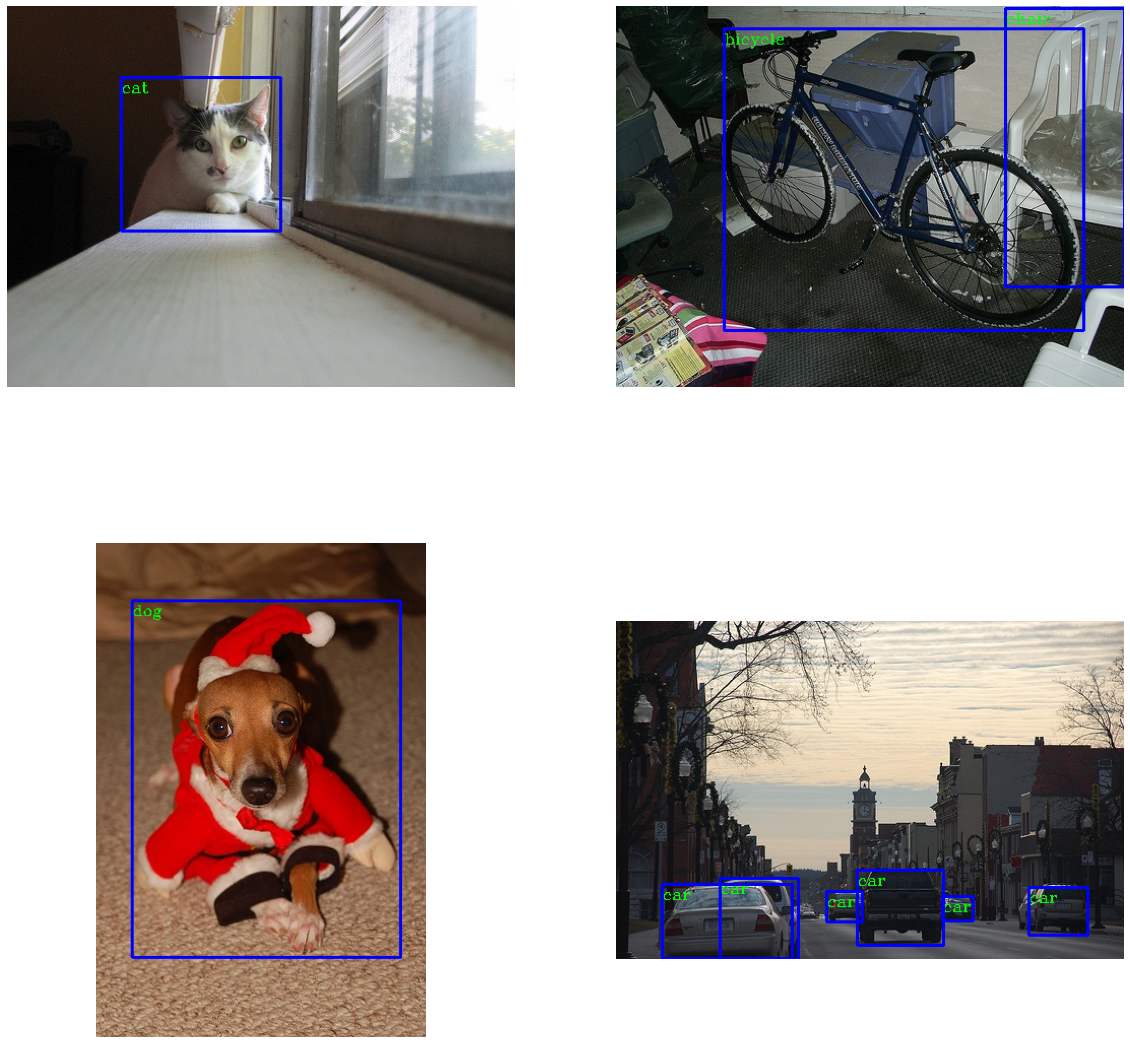

In [ ]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


class Permute(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(-1, 768, 37, 37)

class Interpolate(nn.Module):
    def __init__(self, size=1184):
        super().__init__()
        self.size = size

    def forward(self, x):
      h, w = x.shape[-2:]
      x = nn.ZeroPad2d(padding=(0, self.size-w, 0, self.size-h))(x)
      return x
        # return nn.functional.interpolate(x, size=(1184, 1184),
        #                                  mode='bilinear',
        #                                  align_corners=True)

class ViTFeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = torchvision.models.vit_b_32(image_size=1184)

  def forward(self, x):
    x = self.model._process_input(x)
    n = x.shape[0]

    # Expand the class token to the full batch
    batch_class_token = self.model.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)
    x = self.model.encoder(x)
    x = x[:, 1:]

    return x


class ViTBackbone(nn.Module):
  def __init__(self, vit_model, out_channels=768):
    super().__init__()
    self.out_channels = out_channels
    self.layer0 = nn.Sequential(Interpolate(),
                                vit_model,
                                Permute())

  def forward(self, x):
    x = self.layer0(x)
    return x

num_classes=21

vit_model = ViTFeatureExtractor()
vit_backbone = ViTBackbone(vit_model)

img = torch.randn((1, 3, 896, 974))

in_channels_list = [768]
return_layers = {'layer0': '0'}

out_channels = 768

backbone = BackboneWithFPN(vit_backbone, return_layers, in_channels_list, out_channels)

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512), (32, 64, 128, 256, 512)),
    aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
)

# Final Faster RCNN model.
model = FasterRCNN(
    backbone=backbone,
    num_classes=21,
    rpn_anchor_generator=anchor_generator,
    min_size=(1184, 1184),
    max_size=1184,
    image_mean = [0.485, 0.456, 0.406],
    image_std = [0.229, 0.224, 0.225],

)

# min_size=(1184, 1184),
# max_size=None,
# image_mean = [0.485, 0.456, 0.406],
# image_std = [0.229, 0.224, 0.225],

# transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                                 transforms.Resize(size=(1184, 1184))])

img = torch.randn((1, 3, 384, 384))
model.eval()
out = model(img)


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(1184, 1184), max_size=1184, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (layer0): Sequential(
        (0): Interpolate()
        (1): ViTFeatureExtractor(
          (model): VisionTransformer(
            (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
            (encoder): Encoder(
              (dropout): Dropout(p=0.0, inplace=False)
              (layers): Sequential(
                (encoder_layer_0): EncoderBlock(
                  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                  (self_attention): MultiheadAttention(
                    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                  )
                  (dropout): Dropout(p=0.0, inplace=False)
                  (ln_2): LayerNo

In [ ]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../


from engine import train_one_epoch, evaluate
import utils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-n35y2x84
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-n35y2x84
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397882 sha256=d681da373fa6661cd9e5fb47b56d05af26dae06a7132b82bd1222ded1e686884
  Stored in directory: /tmp/pip-ephem-wheel-cache-mvxytbb4/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6
Cloning into 'vision'...
remote: Enumerating ob

In [ ]:
num_epochs = 21

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [   0/1491]  eta: 4:03:41  lr: 0.000010  loss: 4.0791 (4.0791)  loss_classifier: 3.0324 (3.0324)  loss_box_reg: 0.1287 (0.1287)  loss_objectness: 0.6943 (0.6943)  loss_rpn_box_reg: 0.2237 (0.2237)  time: 9.8062  data: 0.5908  max mem: 8917
Epoch: [0]  [  10/1491]  eta: 0:54:29  lr: 0.000060  loss: 4.0791 (4.0214)  loss_classifier: 3.0326 (3.0325)  loss_box_reg: 0.0752 (0.0873)  loss_objectness: 0.6974 (0.6997)  loss_rpn_box_reg: 0.2237 (0.2019)  time: 2.2078  data: 0.0652  max mem: 9239
Epoch: [0]  [  20/1491]  eta: 0:45:11  lr: 0.000110  loss: 4.0594 (4.0421)  loss_classifier: 3.0297 (3.0301)  loss_box_reg: 0.0747 (0.0857)  loss_objectness: 0.6977 (0.6990)  loss_rpn_box_reg: 0.2020 (0.2273)  time: 1.4454  data: 0.0146  max mem: 9240
Epoch: [0]  [  30/1491]  eta: 0:41:51  lr: 0.000160  loss: 4.0331 (4.0386)  loss_classifier: 3.0241 (3.0266)  loss_box_reg: 0.0881 (0.0969)  loss_objectness: 0.7003 (0.6990)  loss_rpn_box_reg: 0.2014 (0.2162)  time: 1.4507  data: 0.0158  max me

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:  [   0/1000]  eta: 0:16:42  model_time: 0.5763 (0.5763)  evaluator_time: 0.0128 (0.0128)  time: 1.0026  data: 0.4022  max mem: 9241
Test:  [ 100/1000]  eta: 0:08:18  model_time: 0.5242 (0.5248)  evaluator_time: 0.0050 (0.0063)  time: 0.5500  data: 0.0154  max mem: 9241
Test:  [ 200/1000]  eta: 0:07:19  model_time: 0.5248 (0.5221)  evaluator_time: 0.0054 (0.0064)  time: 0.5486  data: 0.0151  max mem: 9241
Test:  [ 300/1000]  eta: 0:06:23  model_time: 0.5190 (0.5217)  evaluator_time: 0.0055 (0.0062)  time: 0.5461  data: 0.0168  max mem: 9241
Test:  [ 400/1000]  eta: 0:05:28  model_time: 0.5208 (0.5218)  evaluator_time: 0.0053 (0.0062)  time: 0.5459  data: 0.0151  max mem: 9241
Test:  [ 500/1000]  eta: 0:04:33  model_time: 0.5212 (0.5215)  evaluator_time: 0.0059 (0.0063)  time: 0.5460  data: 0.0154  max mem: 9241
Test:  [ 600/1000]  eta: 0:03:39  model_time: 0.5210 (0.5213)  evaluator_time: 0.0054 (0.0063)  time: 0.5466  data: 0.0151  max mem: 9241
Test:  [ 700/1000]  eta: 0:02:44  

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:  [   0/1000]  eta: 0:17:25  model_time: 0.5840 (0.5840)  evaluator_time: 0.0116 (0.0116)  time: 1.0452  data: 0.4421  max mem: 9241
Test:  [ 100/1000]  eta: 0:08:20  model_time: 0.5238 (0.5249)  evaluator_time: 0.0066 (0.0085)  time: 0.5495  data: 0.0140  max mem: 9241
Test:  [ 200/1000]  eta: 0:07:21  model_time: 0.5208 (0.5208)  evaluator_time: 0.0067 (0.0095)  time: 0.5591  data: 0.0154  max mem: 9241
Test:  [ 300/1000]  eta: 0:06:25  model_time: 0.5145 (0.5205)  evaluator_time: 0.0067 (0.0090)  time: 0.5432  data: 0.0157  max mem: 9241
Test:  [ 400/1000]  eta: 0:05:29  model_time: 0.5166 (0.5203)  evaluator_time: 0.0073 (0.0088)  time: 0.5438  data: 0.0157  max mem: 9241
Test:  [ 500/1000]  eta: 0:04:34  model_time: 0.5188 (0.5200)  evaluator_time: 0.0076 (0.0087)  time: 0.5468  data: 0.0157  max mem: 9241
Test:  [ 600/1000]  eta: 0:03:39  model_time: 0.5216 (0.5201)  evaluator_time: 0.0071 (0.0089)  time: 0.5484  data: 0.0149  max mem: 9241
Test:  [ 700/1000]  eta: 0:02:44  

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:  [   0/1000]  eta: 0:18:15  model_time: 0.5880 (0.5880)  evaluator_time: 0.0154 (0.0154)  time: 1.0958  data: 0.4786  max mem: 9241
Test:  [ 100/1000]  eta: 0:08:27  model_time: 0.5271 (0.5290)  evaluator_time: 0.0087 (0.0118)  time: 0.5547  data: 0.0147  max mem: 9241
Test:  [ 200/1000]  eta: 0:07:25  model_time: 0.5258 (0.5252)  evaluator_time: 0.0079 (0.0104)  time: 0.5532  data: 0.0156  max mem: 9241
Test:  [ 300/1000]  eta: 0:06:28  model_time: 0.5199 (0.5246)  evaluator_time: 0.0071 (0.0099)  time: 0.5460  data: 0.0143  max mem: 9241
Test:  [ 400/1000]  eta: 0:05:32  model_time: 0.5245 (0.5245)  evaluator_time: 0.0074 (0.0101)  time: 0.5532  data: 0.0163  max mem: 9241
Test:  [ 500/1000]  eta: 0:04:37  model_time: 0.5233 (0.5242)  evaluator_time: 0.0084 (0.0100)  time: 0.5528  data: 0.0168  max mem: 9241
Test:  [ 600/1000]  eta: 0:03:41  model_time: 0.5247 (0.5242)  evaluator_time: 0.0089 (0.0099)  time: 0.5549  data: 0.0162  max mem: 9241
Test:  [ 700/1000]  eta: 0:02:46  

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:  [   0/1000]  eta: 0:18:14  model_time: 0.6304 (0.6304)  evaluator_time: 0.0136 (0.0136)  time: 1.0944  data: 0.4416  max mem: 9241
Test:  [ 100/1000]  eta: 0:08:26  model_time: 0.5270 (0.5287)  evaluator_time: 0.0090 (0.0096)  time: 0.5554  data: 0.0145  max mem: 9241
Test:  [ 200/1000]  eta: 0:07:25  model_time: 0.5243 (0.5250)  evaluator_time: 0.0078 (0.0094)  time: 0.5538  data: 0.0149  max mem: 9241
Test:  [ 300/1000]  eta: 0:06:28  model_time: 0.5224 (0.5244)  evaluator_time: 0.0079 (0.0093)  time: 0.5499  data: 0.0151  max mem: 9241
Test:  [ 400/1000]  eta: 0:05:32  model_time: 0.5226 (0.5243)  evaluator_time: 0.0080 (0.0093)  time: 0.5525  data: 0.0169  max mem: 9241
Test:  [ 500/1000]  eta: 0:04:37  model_time: 0.5241 (0.5239)  evaluator_time: 0.0084 (0.0092)  time: 0.5520  data: 0.0157  max mem: 9241
Test:  [ 600/1000]  eta: 0:03:41  model_time: 0.5242 (0.5239)  evaluator_time: 0.0085 (0.0093)  time: 0.5531  data: 0.0161  max mem: 9241
Test:  [ 700/1000]  eta: 0:02:46  